### Fruit and Vegetable Seasonality Chart

Data is availbale from the [BBC Good Food](https://www.bbcgoodfood.com/seasonal-calendar) website, but it is ordered alphabetically and difficult to read. Lets make it look nicer

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

In [3]:
# I've just copied the html for the tables from the website using the
# elements tab in google chrome developer tools
fruit, veg, meat, fish = pd.read_html('./tables.html', index_col=0)
veg_seasonality = pd.concat([fruit, veg], axis=0)
veg_seasonality[veg_seasonality.isnull()] = 0
veg_seasonality[veg_seasonality == 'Coming in'] = 0.5
veg_seasonality[veg_seasonality == 'At its best'] = 1
veg_seasonality = veg_seasonality.astype('f')
veg_seasonality.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Apple,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
Apricot,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
Banana,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Blackberry,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0,1.0,1.0,0.0,0.0
Blackcurrants,0.0,0.0,0.0,0.0,0.5,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [4]:
def seasonality_start_ends(df):
    df = df.copy()
    df.insert(0, 'prevDec', df['Dec'])
    df.insert(13, 'nextJan', df['Jan'])
    season_coming_in = df.rolling(window=2, axis=1).apply(
        lambda x: True if x[1] and not x[0] else False)
    season_start = df.rolling(window=2, axis=1).apply(
        lambda x: True if x[1] == 1 and x[0] != 1 else False)
    season_end = df.rolling(window=2, axis=1).apply(
        lambda x: True if x[0] and not x[1] else False)
    season_coming_in.drop(['prevDec', 'nextJan'], axis=1, inplace=True)
    season_start.drop(['prevDec', 'nextJan'], axis=1, inplace=True)
    season_end.drop(['prevDec', 'nextJan'], axis=1, inplace=True)
    seasons = np.asarray([np.argmax(season_coming_in.values, axis=1),
                          np.argmax(season_start.values, axis=1),
                          np.argmax(season_end.values, axis=1)]).T
    seasons = pd.DataFrame(seasons,
                           columns=['coming_in', 'start', 'end'],
                           index=df.index)
    seasons[df.all(1)] = np.nan
    return seasons

veg_season_idx = seasonality_start_ends(veg_seasonality).reset_index()
veg_season_idx = veg_season_idx.sort_values(
    by=['coming_in', 'start', 'end', 'index'],
    na_position='last')
veg_seasonality_ordered = veg_seasonality.iloc[veg_season_idx.index]
veg_seasonality_ordered.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Chicory,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lemon,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Orange,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rhubarb,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Purple sprouting broccoli,0.5,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


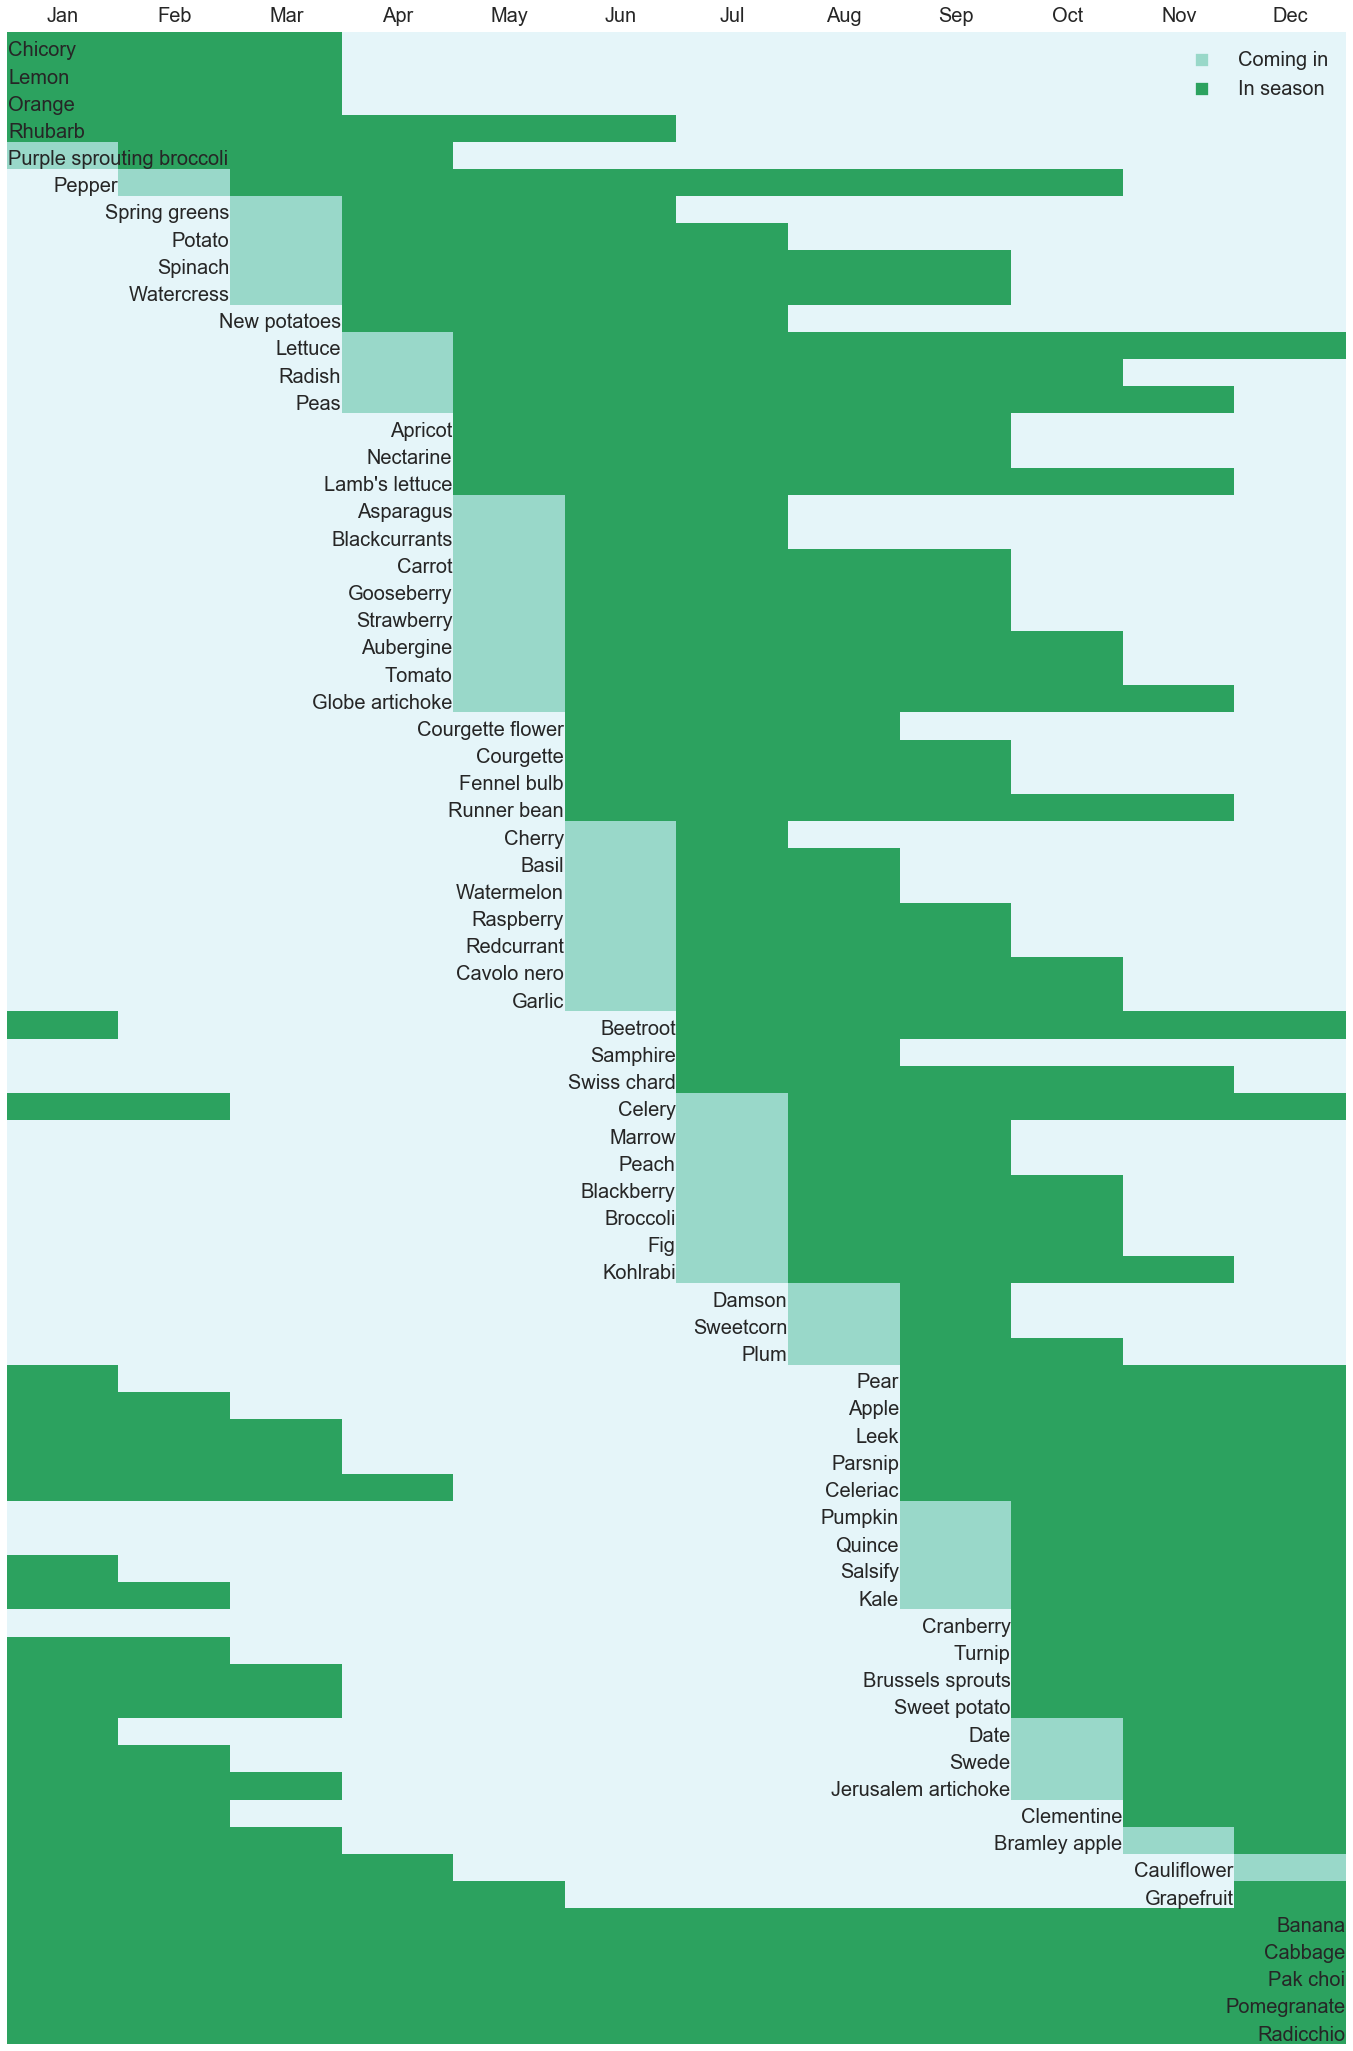

In [27]:
def plot_seasonality_chart(df, idx_df, colors, legend=True):
    cmap = ListedColormap(colors)
    fig, ax = plt.subplots(figsize=(df.shape[1] * 2, df.shape[0] * 0.5))
    sns.heatmap(df, cbar=False, ax=ax, cmap=cmap, yticklabels=False, )
    for y, name, coming_in, start, end in idx_df.reset_index(drop=True).itertuples():
        if not np.isnan(coming_in):
            x = coming_in
        elif not np.isnan(start):
            x = start
        else:
            x = 12
        ha = 'right' if x else 'left'
        x += -0.01 if x else 0.01
        ax.annotate(s=name,
                    xy=(x, len(idx_df) - y - 1),
                    horizontalalignment=ha,
                    verticalalignment='bottom',
                    fontsize=20)
    ax.xaxis.tick_top()
    plt.setp(ax.get_xticklabels(), size=20)
    if legend:
        for text, color in zip(['Coming in', 'In season'], colors[1:]):
            ax.scatter([], [], color=color, label=text, marker='s', s=150)
        plt.legend(loc=1, fontsize=20)
    return ax

colors = ['#e5f5f9', '#99d8c9', '#2ca25f']
ax = plot_seasonality_chart(veg_seasonality_ordered,
                            veg_season_idx,
                            colors,
                            legend=True)
plt.show()

And for the carnivores....

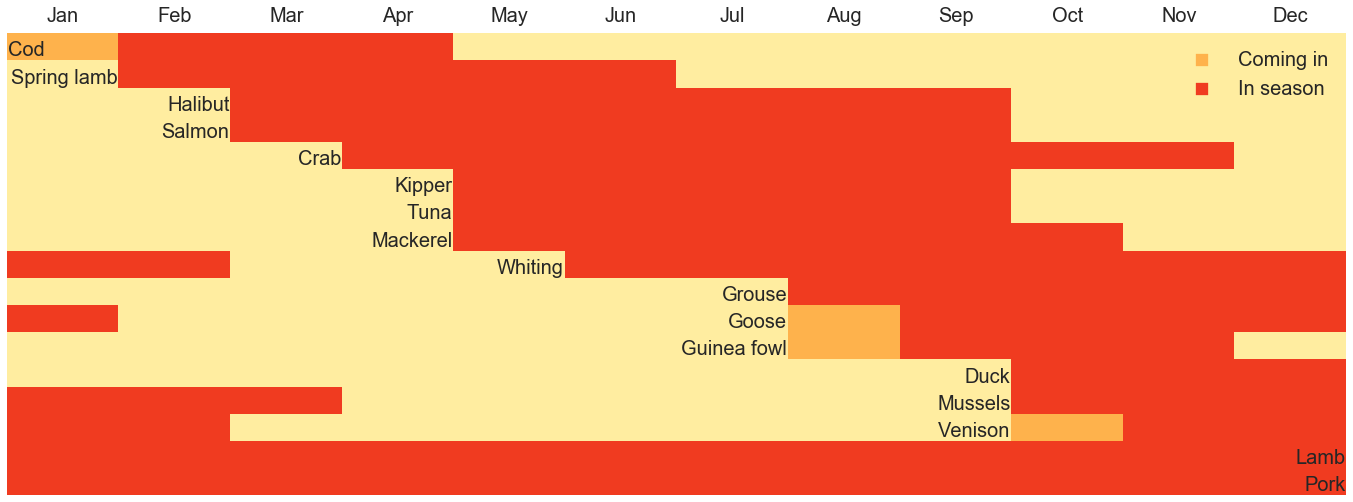

In [21]:
meat_seasonality = pd.concat([meat, fish], axis=0)
meat_seasonality[meat_seasonality.isnull()] = 0
meat_seasonality[meat_seasonality == 'Coming in'] = 0.5
meat_seasonality[meat_seasonality == 'At its best'] = 1
meat_seasonality = meat_seasonality.astype('f')

meat_season_idx = seasonality_start_ends(meat_seasonality).reset_index()
meat_season_idx = meat_season_idx.sort_values(
    by=['coming_in', 'start', 'end', 'index'],
    na_position='last')
meat_seasonality_ordered = meat_seasonality.iloc[meat_season_idx.index]

cmap = ['#ffeda0', '#feb24c', '#f03b20']
ax = plot_seasonality_chart(meat_seasonality_ordered, meat_season_idx, cmap)
plt.show()